In [1]:
!pip install emoji
!pip install tweet-preprocessor
!pip install nltk
!pip install sentencepiece
!pip install keras
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 2.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
from keras.utils import plot_model


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import preprocessor as p
import re
import random



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Preprocessed Data:
      unit_id                                      article_title  \
0  1914947530  Syria attack symptoms consistent with nerve ag...   
1  1914947532  Homs governor says U.S. attack caused deaths b...   
2  1914947533    Death toll from Aleppo bomb attack at least 112   
3  1914947534        Aleppo bomb blast kills six Syrian state TV   
4  1914947535  29 Syria Rebels Dead in Fighting for Key Alepp...   

                                     article_content source       date  \
0  wed apr syria attack symptom consistent nerve ...    nna   4/5/2017   
1  fri apr homs governor say u attack caused deat...    nna   4/7/2017   
2  sun apr death toll aleppo bomb attack least de...    nna  4/16/2017   
3  wed apr aleppo bomb blast kill six syrian stat...    nna  4/19/2017   
4  sun jul syria rebel dead fighting key aleppo r...    nna  7/10/2016   

  location  labels  Unnamed: 7  Unnamed: 8  Unnamed: 9 Unnamed: 10  
0    idlib       0         NaN         NaN         NaN    

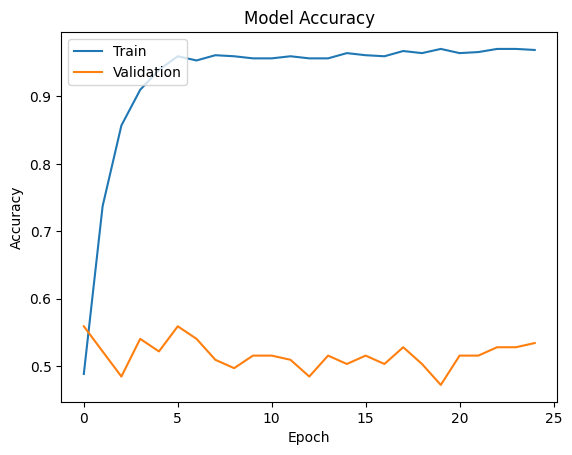

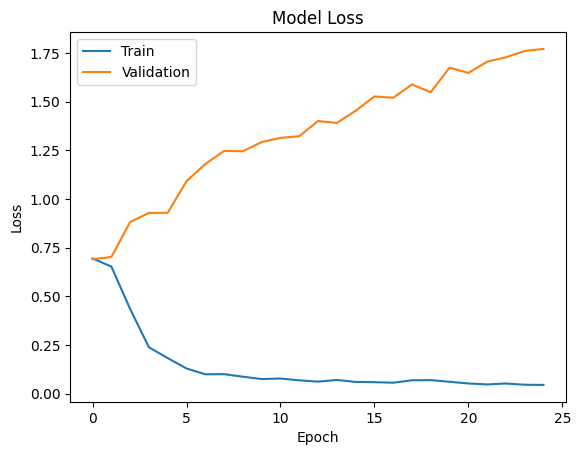

In [3]:
# Load the dataset
file_path = '/content/FA-KES-Dataset.csv'
data = pd.read_csv(file_path, encoding="Latin-1")

# Define the random deletion function
def random_deletion(text, p=0.1):
    # Split the text into words
    words = text.split()
    # Calculate the number of words to delete
    num_words_to_delete = max(1, int(len(words) * p))
    # Randomly select words to delete
    words_to_delete = random.sample(words, num_words_to_delete)
    # Remove the selected words from the text
    augmented_text = ' '.join([word for word in words if word not in words_to_delete])
    return augmented_text

# Apply data augmentation to create augmented samples
augmented_samples = []
for text in data['article_content']:
    augmented_text = random_deletion(text)
    augmented_samples.append(augmented_text)

# Add augmented samples to the original dataset
augmented_data = pd.DataFrame({'article_content': augmented_samples, 'labels': data['labels']})

# Concatenate the original and augmented datasets
augmented_data = pd.concat([data, augmented_data], ignore_index=True)

# Shuffle the dataset
augmented_data = augmented_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Preprocess the text data
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Use tweet-preprocessor to remove URLs, mentions, hashtags, and emojis
    text = p.clean(text)

    # Remove punctuation except for numbers
    text = re.sub(r'[^\w\s\d]|_', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(lemmatized_tokens)

    return preprocessed_text

# Applying text preprocessing to the "tweet" column in both data and val_data
data['article_content'] = data['article_content'].apply(preprocess_text)

print("Preprocessed Data:")
print(data.head())

data['article_content'] = data['article_content'].apply(preprocess_text)

# Separate features and labels
X = data['article_content']
y = data['labels']

# Tokenize and pad sequences
max_words = 10000
maxlen = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=maxlen)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Define the function to create the model
def create_model(embedding_dim=128, lstm_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen))
    model.add(Bidirectional(LSTM(lstm_units)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define best hyperparameters
best_hyperparameters = {'embedding_dim': 256, 'lstm_units': 64, 'dropout_rate': 0.4}

# Create and train the model with the best hyperparameters
model = create_model(embedding_dim=best_hyperparameters['embedding_dim'],
                     lstm_units=best_hyperparameters['lstm_units'],
                     dropout_rate=best_hyperparameters['dropout_rate'])
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), verbose=0)

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)

print("Best Validation Accuracy:", max(history.history['val_accuracy']))
print("Test Accuracy:", accuracy)


plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Best hyperparameters: {'embedding_dim': 256, 'lstm_units': 64, 'dropout_rate': 0.4}
# Best validation accuracy: 0.5838509202003479

In [5]:
import numpy as np

# Assuming you have your true labels and predicted probabilities from your dataset
true_labels = y_val
predicted_probabilities = model.predict(X_val)

# Threshold the predicted probabilities to obtain binary predictions
predicted_labels = (predicted_probabilities > 0.5).astype(int)

# Flatten the predicted labels array
predicted_labels_flattened = predicted_labels.flatten()

# Reshape the predicted labels array to match the shape of the true labels array
predicted_labels_reshaped = predicted_labels_flattened[:len(true_labels)]

# Compute true positives, false positives, false negatives
tp = np.sum((true_labels == 1) & (predicted_labels_reshaped == 1))
fp = np.sum((true_labels == 0) & (predicted_labels_reshaped == 1))
fn = np.sum((true_labels == 1) & (predicted_labels_reshaped == 0))

# Compute precision, recall, and F1 score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


6/6 [==============================] - 0s 51ms/step
Precision: 0.5897435897435898
Recall: 0.5168539325842697
F1 Score: 0.5508982035928144
